In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from PIL import Image
import pydicom
import matplotlib.pyplot as plt
import numpy as np

##Import any other packages you may need here

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_xray_df.sample(3)

data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2685,00013582_000.png,Fibrosis,0,13582,027Y,F,PA,2048,2500,0.168,0.168
1936,00010092_039.png,Fibrosis|Nodule|Pleural_Thickening,39,10092,050Y,F,PA,2992,2991,0.143,0.143
3125,00015406_012.png,No Finding,12,15406,038Y,M,AP,2500,2048,0.168,0.168


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## EDA
# Todo 
males = len(data_sample[data_sample["Patient Gender"] == "M"])/len(data_sample)
females = 1 - males

ap = len(data_sample[data_sample["View Position"] == "AP"])/len(data_sample)
pa = 1 - ap


labels = data_sample["Finding Labels"].unique() 
labels_pneumonia = [l for l in labels if "Pneumonia" in l]
total_cases = len(data_sample)
pneumonia_patients = [f for f in data_sample["Finding Labels"] if "Pneumonia" in f]

# print("Unique Labels {}".format(len(labels)))
print("Labels with pneumonia {}/244".format(len(labels_pneumonia)))

# print("Total Number of cases {}".format(total_cases))
print("Number of patients with Pneumonia {}/5606".format(len(pneumonia_patients)))
# print(data_sample["Finding Labels"])
print("male patients {:.2f}%".format(males*100))
print("female patients {:.2f}%".format(females*100))
ls = [l.split("|") for l in labels]
newlist = [item for items in ls for item in items]
print("Number of diseases: {}".format(len(set(newlist))))

Labels with pneumonia 29/244
Number of patients with Pneumonia 62/5606
male patients 55.90%
female patients 44.10%
Number of diseases: 15


In [4]:
d = all_xray_df.copy()

In [5]:
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
d.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
10614,00002750_000.png,No Finding,0,2750,22,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40268,00010491_004.png,No Finding,4,10491,55,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15048,00003945_008.png,No Finding,8,3945,41,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
len(all_labels)

15

In [7]:
d[all_labels].sum()/len(d)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

<IPython.core.display.Javascript object>


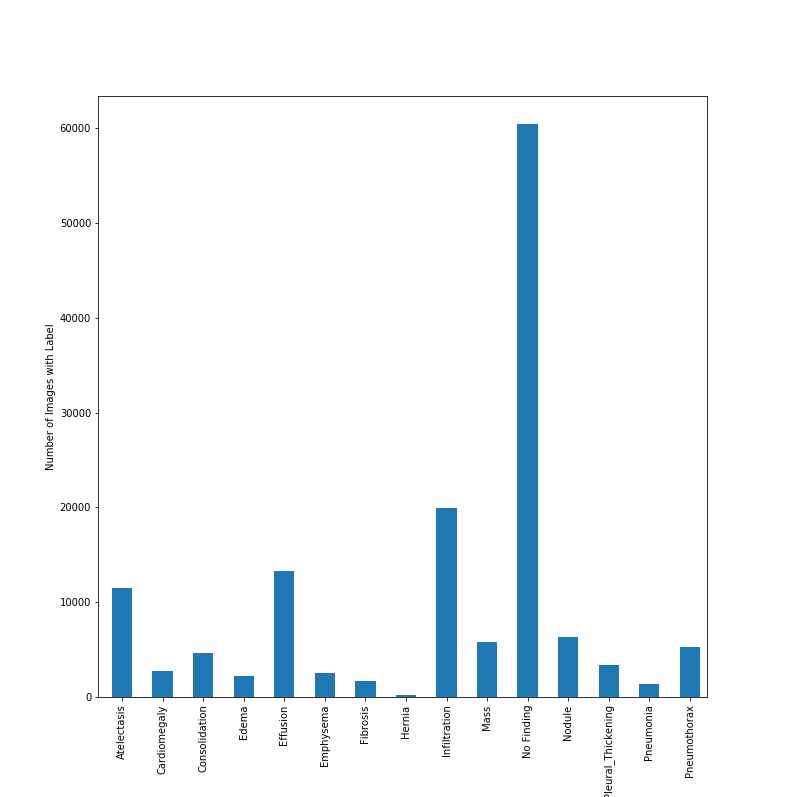

In [8]:
ax = d[all_labels].sum().plot(kind='bar')
_ = ax.set(ylabel = 'Number of Images with Label')

<IPython.core.display.Javascript object>


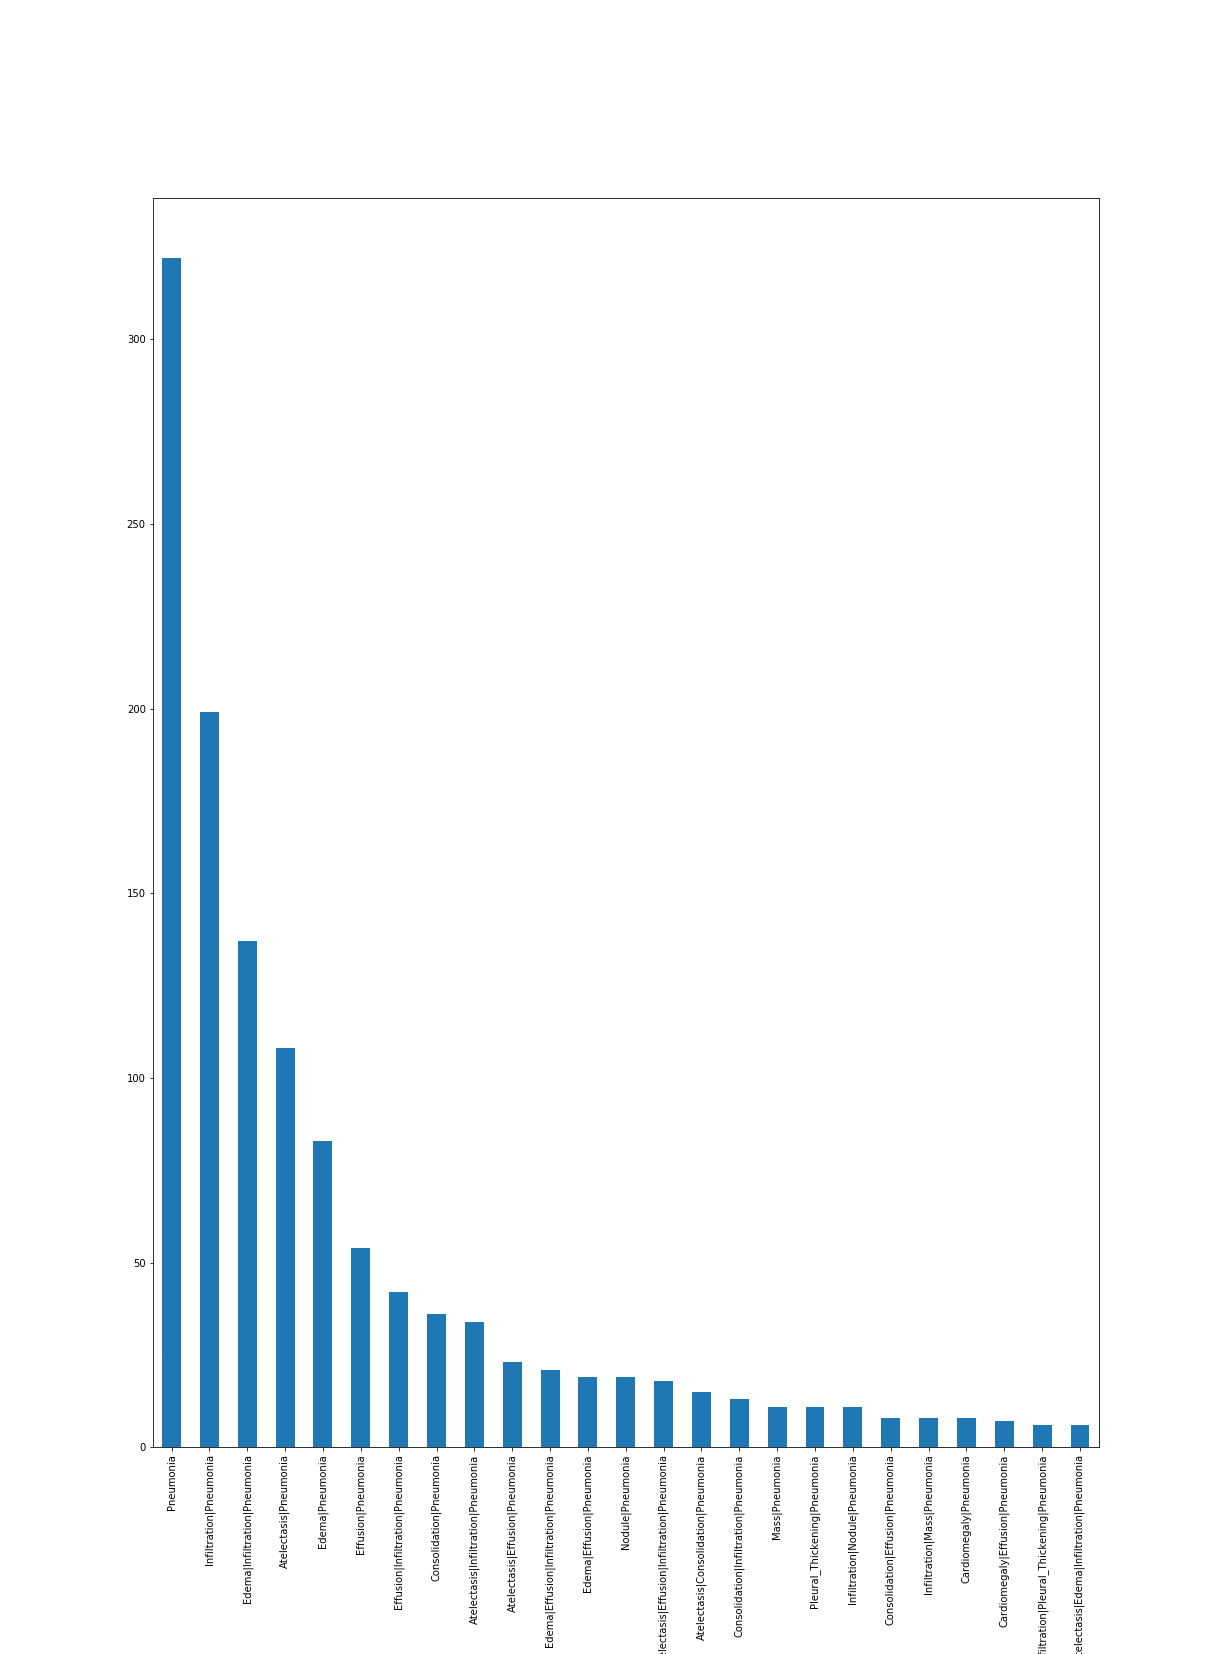

In [9]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
_ = d[d.Pneumonia==1]['Finding Labels'].value_counts()[0:25].plot(kind='bar')

In [10]:
# There seems to be some unreasonable outliers whic I remove
d['Patient Age'][d['Patient Age'] >= 120] = 120

/media/spiros/diskoyext/anaconda3/envs/aihealth/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


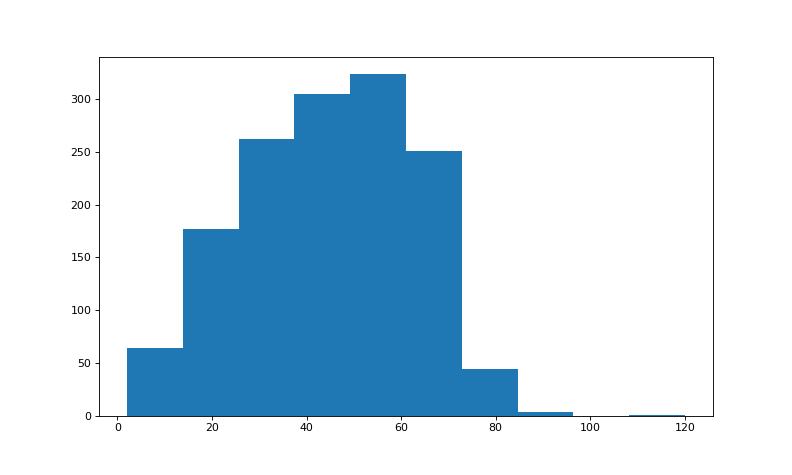

In [11]:
plt.figure(figsize=(10,6))
_ = plt.hist([d[d.Pneumonia==1]['Patient Age'].values])

<IPython.core.display.Javascript object>


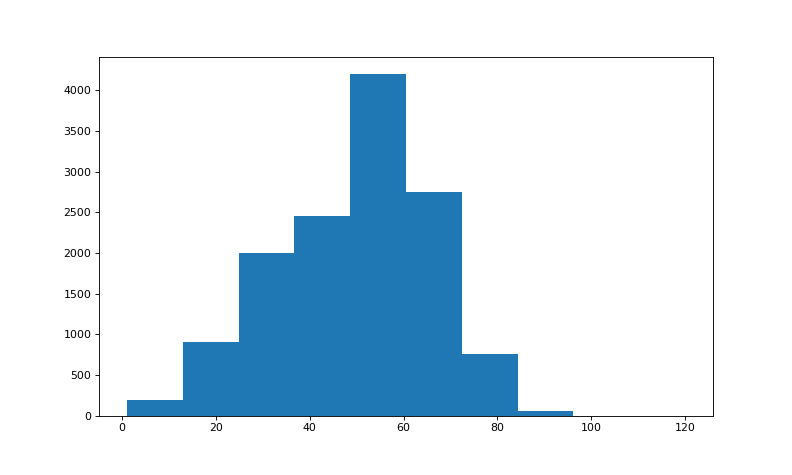

In [12]:
plt.figure(figsize=(10,6))
_ = plt.hist(d[d.Effusion==1]['Patient Age'])

<IPython.core.display.Javascript object>


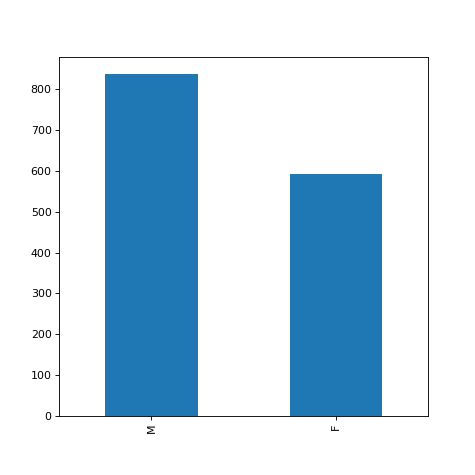

In [13]:
# Pneumonia distribution regarding gender
plt.figure(figsize=(6,6))
_ = d[d.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

# **Describe your findings and how will you set up the model training based on the findings.**

A part of the detections consists of pneumonia findings but there are many other findings. In the dataset for the training I will need to balance it so that they're two categories Pneumonia and no-pneumonia that are equal in the training dataset.

<IPython.core.display.Javascript object>


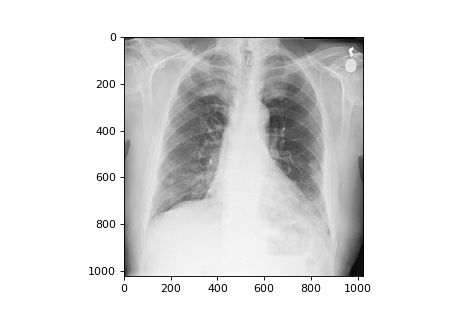

In [15]:
dcm = pydicom.dcmread('test1.dcm')
_ = plt.imshow(dcm.pixel_array,cmap='gray')

### Plot instagram of intensity values

<IPython.core.display.Javascript object>


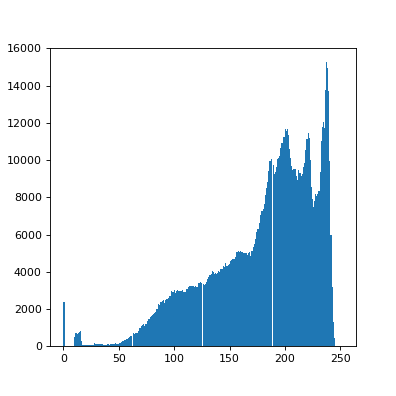

In [16]:
plt.figure(figsize=(5,5))
_ = plt.hist(dcm.pixel_array.ravel(), bins = 256)

### Re-plot a histogram of the normalized intensity values

In [17]:
mean_intensity = np.mean(dcm.pixel_array)
std_intensity = np.std(dcm.pixel_array)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity

<IPython.core.display.Javascript object>


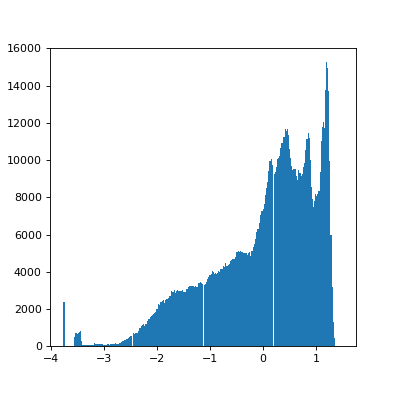

In [18]:
plt.figure(figsize=(5,5))
_ = plt.hist(new_img.ravel(), bins = 256)

In [19]:
import random 
a = d[d.Pneumonia==1]['Finding Labels'].unique()

d1 = "Edema|Infiltration|Pneumonia"
d2 = "Infiltration|Pneumonia"
d3 = "Pneumonia"
d[d["Finding Labels"] == d3]

pneumonia_case = d[d['Finding Labels'] == d3].iloc[2]["Image Index"]
infil_case = d[d['Finding Labels'] == "Infiltration"].iloc[2]["Image Index"]

edema_case = d[d['Finding Labels'] == "Edema"].iloc[2]["Image Index"]

infil_pn_case = d[d['Finding Labels'] == d2].iloc[2]["Image Index"]
edema_infil_pn_case = d[d['Finding Labels'] == d1].iloc[2]["Image Index"]

In [20]:
import os
from fnmatch import fnmatch

filenames = {}
root = 'data'
pattern = "*.png"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            filenames[name] = os.path.join(path, name)
            
pneumonia_case_file = filenames[pneumonia_case]
infil_case_file = filenames[infil_case]
edema_case_file = filenames[edema_case]
infil_pn_case_file = filenames[infil_pn_case]
edema_infil_pn_case_file = filenames[edema_infil_pn_case]

<IPython.core.display.Javascript object>


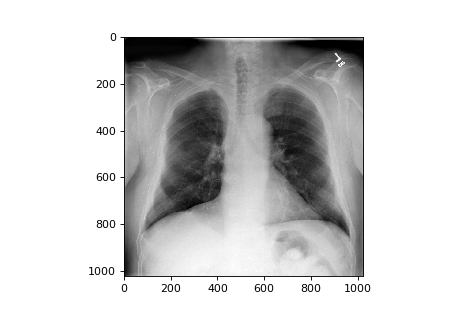

In [21]:
img = Image.open(pneumonia_case_file)
_ = plt.imshow(img,cmap='gray')

In [22]:
mean_intensity = np.mean(img)
std_intensity = np.std(img)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity

<IPython.core.display.Javascript object>


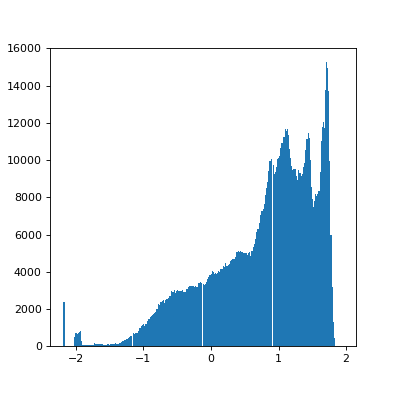

In [23]:
plt.figure(figsize=(5,5))
_ = plt.hist(new_img.ravel(), bins = 256)

<IPython.core.display.Javascript object>


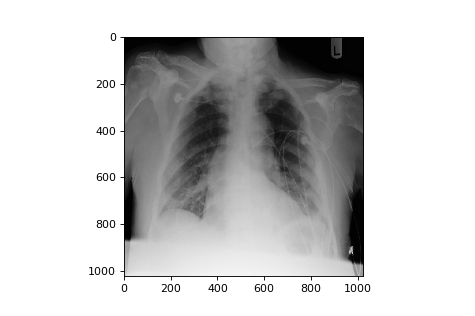

In [24]:
img = Image.open(infil_case_file)
_ = plt.imshow(img,cmap='gray')

<IPython.core.display.Javascript object>


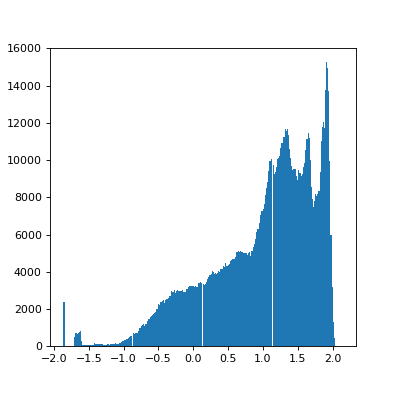

In [25]:
mean_intensity = np.mean(img)
std_intensity = np.std(img)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
_ = plt.hist(new_img.ravel(), bins = 256)

<IPython.core.display.Javascript object>


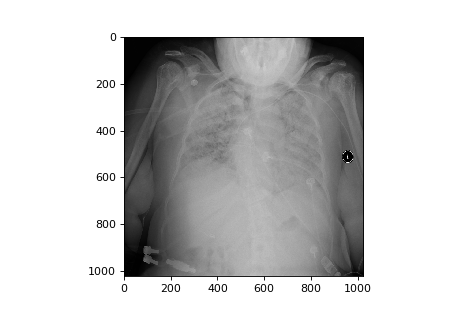

In [26]:
img = Image.open(edema_case_file)
_ = plt.imshow(img,cmap='gray')

<IPython.core.display.Javascript object>


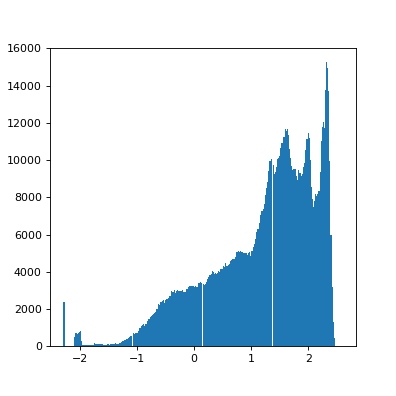

In [27]:
mean_intensity = np.mean(img)
std_intensity = np.std(img)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
_ = plt.hist(new_img.ravel(), bins = 256)

<IPython.core.display.Javascript object>


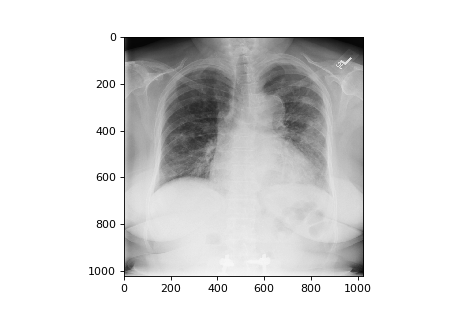

In [28]:
img = Image.open(infil_pn_case_file)
_ = plt.imshow(img,cmap='gray')

<IPython.core.display.Javascript object>


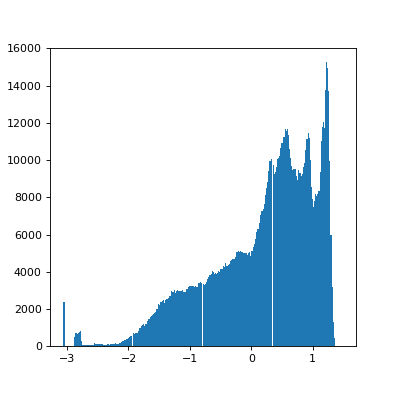

In [29]:
mean_intensity = np.mean(img)
std_intensity = np.std(img)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
_ = plt.hist(new_img.ravel(), bins = 256)

<IPython.core.display.Javascript object>


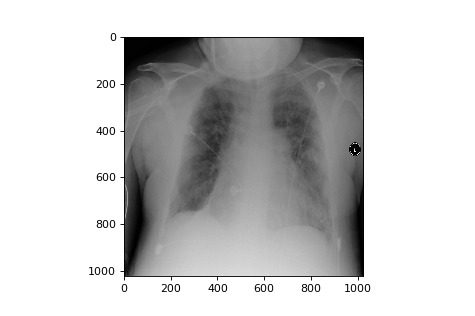

In [30]:
img = Image.open(edema_infil_pn_case_file)
_ = plt.imshow(img,cmap='gray')

<IPython.core.display.Javascript object>


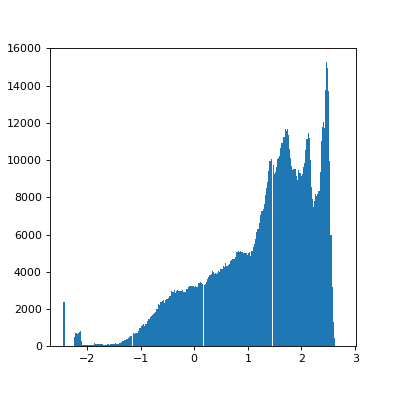

In [31]:
mean_intensity = np.mean(img)
std_intensity = np.std(img)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
_ = plt.hist(new_img.ravel(), bins = 256)

### *The normalized intensity values seem to be very similar within and across diagnoses. Perhaps a more trained eye could notice something more interesting.*